In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import os

# Imports pour scikit-learn (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 

# Affichage dans Jupyter
try:
    from IPython.display import display, clear_output
except ImportError:
    display = print 
    clear_output = lambda wait=False: os.system('cls' if os.name == 'nt' else 'clear')

In [14]:
## --- Fichier CSV BRUT contenant les coups de référence ---
REFERENCE_SESSION_CSV = r'C:\Users\laptop\Desktop\P2I\ProjetP\projet_gant_boxe\fichiers_csv\session_brute_20xuppercut.csv' 

# --- Paramètres de Détection des Coups (identiques à analyse_coups.py) ---

SMOOTHING_WINDOW_SIZE_KNN = 15
ACCEL_Y_PEAK_HEIGHT_KNN = 1.0 
ACCEL_Y_FIRST_PEAK_PROMINENCE_KNN = 0.4
ACCEL_Y_SECOND_PEAK_PROMINENCE_KNN = 0.15
ACCEL_Y_PEAK_DISTANCE_KNN = 4
MAX_GAP_SECONDS_FOR_PAIRS_KNN = 1.0
ROTATION_EXTREMA_MARGIN_SECONDS_KNN = 0.25

ENERGY_ACTIVITY_THRESHOLD = 2  # Seuil sur l'enveloppe d'énergie 
MIN_DURATION_SAMPLES_ENERGY = 5 # Durée minimale d'un coup en nombre d'échantillons 
MERGE_GAP_SAMPLES_ENERGY = 10    # Gap max (échantillons) pour fusionner deux segments actifs
SAMPLING_INTERVAL_SECONDS = 0.01  # Intervalle d'échantillonnage de l'Arduino (10ms = 0.01s)

# Colonnes de caractéristiques (features) pour le KNN (pour information)
FEATURES_COLUMNS = [
    'Min_AccX_Val', 'Max_AccX_Val', 'AccX_Amplitude', 'AccX_Ord(1=Max>Min)',
    'Min_AccZ_Val', 
    'Max_Roll_Val', 'Min_Roll_Val', 'Roll_Ord(1=Max>Min)',
    'Max_Pitch_Val', 'Min_Pitch_Val', 'Pitch_Ord(1=Max>Min)'
]

In [15]:
def load_reference_csv_data(filename):
    """Charge les données CSV issues du serveur et renomme Gyro en Roll/Pitch/Yaw."""
    if not os.path.exists(filename):
        print(f"ERREUR: Le fichier '{filename}' n'existe pas.")
        return None
    try:
        df = pd.read_csv(filename)
        print(f"Fichier '{filename}' chargé. {len(df)} lignes lues.")
        df['Time'] = pd.to_datetime(df['TimestampReception'])
        if 'SeqNum' in df.columns:
            df['SeqNum'] = pd.to_numeric(df['SeqNum'], errors='coerce')
            df.dropna(subset=['SeqNum'], inplace=True)
            df = df.sort_values(by='SeqNum').reset_index(drop=True)
            first_seq_num = df['SeqNum'].iloc[0]
            t0_reception = df['Time'].iloc[0] 
            SAMPLING_INTERVAL_SECONDS = 0.01 
            df['Time'] = t0_reception + pd.to_timedelta( (df['SeqNum'] - first_seq_num) * SAMPLING_INTERVAL_SECONDS, unit='s')
            print("Colonne 'Time' recalculée pour le fichier de référence.")
        cols_to_convert = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
        for col in cols_to_convert:
            if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
        rename_map = {'GyroX': 'Roll', 'GyroY': 'Pitch', 'GyroZ': 'Yaw'}
        df.rename(columns=rename_map, inplace=True)
        df.dropna(subset=["Time", "AccX", "AccY", "AccZ", "Roll", "Pitch", "Yaw"], inplace=True)
        print(f"{len(df)} lignes valides après chargement et nettoyage.")
        if df.empty: raise ValueError("Aucune donnée valide.")
        return df
    except Exception as e:
        print(f"ERREUR lors du chargement: {e}")
        return None

def smooth_data_knn(df_column, window_size=SMOOTHING_WINDOW_SIZE_KNN):
    if window_size <= 0 or len(df_column) < window_size: return df_column
    return df_column.rolling(window=window_size, center=True, min_periods=1).mean()


def identify_pairs_knn(peak_original_indices, prominences_values, df_for_time, max_gap_seconds=MAX_GAP_SECONDS_FOR_PAIRS_KNN):
    """Identifie les paires de pics (repris de votre code KNN)."""
    pairs = []
    i = 0
    while i < len(peak_original_indices) - 1:
        idx1_orig, idx2_orig = peak_original_indices[i], peak_original_indices[i+1]
        if not (idx1_orig in df_for_time.index and idx2_orig in df_for_time.index):
            i+=1
            continue
        time_diff = (df_for_time['Time'].loc[idx2_orig] - df_for_time['Time'].loc[idx1_orig]).total_seconds()
        if 0 < time_diff < max_gap_seconds and \
           prominences_values[i] >= ACCEL_Y_FIRST_PEAK_PROMINENCE_KNN and \
           prominences_values[i+1] >= ACCEL_Y_SECOND_PEAK_PROMINENCE_KNN:
            pairs.append((idx1_orig, idx2_orig))
            i += 2
        else:
            i += 1
    return pairs


def identify_coup_segments(df_full_data):
    """
    Identifie les segments de coups (paires de pics AccY) dans le DataFrame complet.
    Retourne une liste de tuples (index_debut_original, index_fin_original).
    """
    required_cols_for_smoothing = ['AccX', 'AccY', 'AccZ', 'Roll', 'Pitch', 'Yaw']
    for col in required_cols_for_smoothing:
        if col in df_reference_session.columns:
            
            df_reference_session[f'{col}_Smoothed'] = smooth_data_knn(df_reference_session[col]) 

    if 'AccY_Smoothed' not in df_full_data.columns:
        print("ERREUR: La colonne 'AccY_Smoothed' est requise et n'a pas été trouvée dans identify_coup_segments.")
        return []

    plot_df_accel_y = df_full_data[['Time', 'AccY_Smoothed']].dropna().copy()
    if plot_df_accel_y.empty or len(plot_df_accel_y) < ACCEL_Y_PEAK_DISTANCE_KNN :
        print("Pas assez de données AccY après lissage pour trouver des pics.")
        return []

    peaks_pos, properties = find_peaks(
        plot_df_accel_y['AccY_Smoothed'].to_numpy(),
        height=ACCEL_Y_PEAK_HEIGHT_KNN, distance=ACCEL_Y_PEAK_DISTANCE_KNN,
        prominence=ACCEL_Y_SECOND_PEAK_PROMINENCE_KNN
    )
    
    accel_y_peaks_original_indices = plot_df_accel_y.index[peaks_pos].tolist()
    prominences_for_pairs = properties['prominences']
    
    
    accel_y_pairs = identify_pairs_knn(
        accel_y_peaks_original_indices, 
        prominences_for_pairs, 
        df_full_data,
        MAX_GAP_SECONDS_FOR_PAIRS_KNN
    )
    return accel_y_pairs

def classify_order_extrema_knn(idx_min, idx_max):
    if idx_min is None or idx_max is None or pd.isna(idx_min) or pd.isna(idx_max): return np.nan
    if idx_min < idx_max: return 0 
    elif idx_max < idx_min: return 1
    else: return np.nan

def find_rotation_extrema_knn(df, column_name, peak1_idx, peak2_idx, margin_seconds=ROTATION_EXTREMA_MARGIN_SECONDS_KNN):
    if peak1_idx is None or peak2_idx is None or not (peak1_idx in df.index and peak2_idx in df.index): 
        return None, None, np.nan, np.nan
    time_peak1 = df['Time'].loc[peak1_idx]
    time_peak2 = df['Time'].loc[peak2_idx]
    start_time = time_peak1 - pd.Timedelta(seconds=margin_seconds)
    end_time = time_peak2 + pd.Timedelta(seconds=margin_seconds)
    segment = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]
    if segment.empty or column_name not in segment.columns or segment[column_name].isnull().all(): 
        return None, None, np.nan, np.nan
    vals = segment[column_name]
    max_val, min_val = vals.max(), vals.min()
    max_idx = vals.idxmax() if pd.notna(max_val) else None
    min_idx = vals.idxmin() if pd.notna(min_val) else None
    return max_idx, min_idx, max_val, min_val


def extract_features_from_segment(df_full, p1_idx, p2_idx):
    # Initialisation avec les clés de FEATURES_COLUMNS
    features = {col_name: np.nan for col_name in FEATURES_COLUMNS}

    # ... (vérifications des index et du segment vide) ...
    seg = df_full.loc[p1_idx:p2_idx]
    if seg.empty: return features

    # AccX
    if 'AccX_Smoothed' in seg.columns: # Utilise le nom de colonne du DataFrame
        ax_seg = seg['AccX_Smoothed']
        if not ax_seg.empty and not ax_seg.isnull().all():
            min_val = ax_seg.min()
            max_val = ax_seg.max()
            
            features['Min_AccX_Val'] = min_val 
            features['Max_AccX_Val'] = max_val
            if pd.notna(min_val) and pd.notna(max_val):
                features['AccX_Amplitude'] = max_val - min_val
            features['AccX_Ord(1=Max>Min)'] = classify_order_extrema_knn(ax_seg.idxmin(), ax_seg.idxmax())

    # AccZ
    if 'AccZ_Smoothed' in seg.columns: 
        az_seg = seg['AccZ_Smoothed']
        if not az_seg.empty and not az_seg.isnull().all():
            min_val_z = az_seg.min()
            features['Min_AccZ_Val'] = min_val_z 
            print(f"    Min_AccZ_Val calculé et assigné : {min_val_z}")
    else:
        print(f"  DEBUG: Colonne AccZ_Smoothed MANQUANTE dans le segment {p1_idx}-{p2_idx} !")
        print(f"    Colonnes disponibles dans le segment : {seg.columns.tolist()}")


    # Roll
    if 'Roll_Smoothed' in df_full.columns:
        max_roll_idx, min_roll_idx, max_roll_val, min_roll_val = find_rotation_extrema_knn(df_full, 'Roll_Smoothed', p1_idx, p2_idx)
        features['Max_Roll_Val'] = max_roll_val
        features['Min_Roll_Val'] = min_roll_val
        features['Roll_Ord(1=Max>Min)'] = classify_order_extrema_knn(min_roll_idx, max_roll_idx)

    # Pitch
    if 'Pitch_Smoothed' in df_full.columns:
        max_pitch_idx, min_pitch_idx, max_pitch_val, min_pitch_val = find_rotation_extrema_knn(df_full, 'Pitch_Smoothed', p1_idx, p2_idx)
        features['Max_Pitch_Val'] = max_pitch_val
        features['Min_Pitch_Val'] = min_pitch_val
        features['Pitch_Ord(1=Max>Min)'] = classify_order_extrema_knn(min_pitch_idx, max_pitch_idx)

    return features

def calculate_accel_magnitude_smoothed(df, ax_col='AccX_Smoothed', ay_col='AccY_Smoothed', az_col='AccZ_Smoothed'):
    """Calcule la magnitude lissée du vecteur d'accélération."""
    # S'assure que les colonnes lissées existent
    required_cols = [ax_col, ay_col, az_col]
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"ERREUR (Magnitude): Colonnes lissées requises manquantes: {missing_cols}")
        return None
    return np.sqrt(df[ax_col]**2 + df[ay_col]**2 + df[az_col]**2)

def calculate_energy_envelope(signal_series, window_size=15):
    """Calcule l'enveloppe d'énergie (moyenne mobile du signal au carré)."""
    if signal_series is None or signal_series.empty:
        return pd.Series(dtype=float) # Retourne une Series vide
    squared_signal = signal_series**2
    return squared_signal.rolling(window=window_size, center=True, min_periods=1).mean()

def segment_coups_par_energie(df, 
                               energy_envelope_signal, 
                               activity_threshold, 
                               min_duration_samples=10, # Valeur par défaut
                               merge_gap_samples=5):    # Valeur par défaut
    """
    Segmente les coups en utilisant un seuil sur l'enveloppe d'énergie.
    Retourne une liste de tuples (index_debut_original, index_fin_original).
    """
    if energy_envelope_signal.empty:
        print("DEBUG (segment_coups_par_energie): energy_envelope_signal est vide.")
        return []

    print(f"DEBUG: activity_threshold = {activity_threshold}")
    active_regions = (energy_envelope_signal > activity_threshold)
    print(f"DEBUG: Nombre de points actifs (au-dessus du seuil): {active_regions.sum()} sur {len(active_regions)}")

    if not active_regions.any(): # Si aucune région n'est active
        print("DEBUG: Aucune région active détectée (tout est sous le seuil).")
        return []

    change_points = active_regions.astype(int).diff()
    start_indices_pos = np.where(change_points == 1)[0]
    end_indices_pos = np.where(change_points == -1)[0]

    # Utiliser l'index de energy_envelope_signal qui devrait correspondre à df
    start_indices = energy_envelope_signal.index[start_indices_pos].tolist()
    end_indices = energy_envelope_signal.index[end_indices_pos].tolist()
    
    print(f"DEBUG: Start_indices bruts (positions): {start_indices_pos}")
    print(f"DEBUG: End_indices bruts (positions): {end_indices_pos}")
    print(f"DEBUG: Start_indices (valeurs d'index): {start_indices}")
    print(f"DEBUG: End_indices (valeurs d'index): {end_indices}")

    # Gérer les cas où le signal commence ou finit en état actif
    if active_regions.iloc[0]: # Si le premier point est actif
        if not start_indices or start_indices[0] != energy_envelope_signal.index[0]:
             start_indices.insert(0, energy_envelope_signal.index[0])
             print(f"DEBUG: Ajout d'un start_index au début: {energy_envelope_signal.index[0]}")
    if active_regions.iloc[-1]: # Si le dernier point est actif
        if not end_indices or end_indices[-1] < energy_envelope_signal.index[-1]:
            end_indices.append(energy_envelope_signal.index[-1])
            print(f"DEBUG: Ajout d'un end_index à la fin: {energy_envelope_signal.index[-1]}")
    
    print(f"DEBUG: Start_indices (après ajustement bords): {start_indices}")
    print(f"DEBUG: End_indices (après ajustement bords): {end_indices}")

    # Assembler les segments
    segments = []
    current_e_idx_pos_in_list = 0 
    for s_val in start_indices:
        possible_ends = [e_val for e_val in end_indices[current_e_idx_pos_in_list:] if e_val > s_val]
        if possible_ends:
            e_val_chosen = possible_ends[0]
            segments.append((s_val, e_val_chosen))
            try:
                current_e_idx_pos_in_list = end_indices.index(e_val_chosen, current_e_idx_pos_in_list) + 1
            except ValueError:
                 current_e_idx_pos_in_list = len(end_indices)
        elif active_regions.loc[s_val:].any(): # Si commence actif et pas de fin trouvée, va jusqu'au bout
            segments.append((s_val, energy_envelope_signal.index[-1]))
            print(f"DEBUG: Segment allant jusqu'à la fin: ({s_val}, {energy_envelope_signal.index[-1]})")
            break 
    
    print(f"DEBUG: Segments bruts formés ({len(segments)}): {segments}")

    # Filtrer par durée minimale
    segments_duree_ok = []

    min_required_duration_seconds = min_duration_samples * SAMPLING_INTERVAL_SECONDS
    print(f"DEBUG: min_duration_samples: {min_duration_samples}, SAMPLING_INTERVAL_SECONDS: {SAMPLING_INTERVAL_SECONDS:.4f}, min_required_duration_seconds: {min_required_duration_seconds:.4f}s")

    for k, (s, e) in enumerate(segments):
        if s in df.index and e in df.index and s <= e:
            duration_in_seconds = (df.loc[e, 'Time'] - df.loc[s, 'Time']).total_seconds()
            print(f"DEBUG: Segment brut {k+1} (Indices {s}-{e}): Durée = {duration_in_seconds:.4f}s")
            if duration_in_seconds >= min_required_duration_seconds:
                segments_duree_ok.append((s, e))
            else:
                print(f"DEBUG: Segment brut {k+1} REJETÉ par filtre durée (trop court).")
        else:
            print(f"DEBUG: Indices de segment ({s}, {e}) invalides ou s > e. Ignoré pour filtre durée.")
    
    print(f"DEBUG: Segments après filtre durée ({len(segments_duree_ok)}): {segments_duree_ok}")
    if not segments_duree_ok: return []

    # Fusionner les segments proches
    merged_segments = []
    if not segments_duree_ok: # Double vérification
        return []
        
    current_start, current_end = segments_duree_ok[0]
    for i in range(1, len(segments_duree_ok)):
        next_start, next_end = segments_duree_ok[i]
        
        # Calcul du gap en nombre d'échantillons. 
        try:
            gap_indices_count = df.index.get_loc(next_start) - df.index.get_loc(current_end) - 1
        except KeyError:
            print(f"DEBUG: Erreur de clé lors du calcul du gap pour {next_start} ou {current_end}. Fusion sautée pour ce segment.")
            # En cas d'erreur, on ne fusionne pas et on passe au segment suivant comme un nouveau segment.
            merged_segments.append((current_start, current_end))
            current_start, current_end = next_start, next_end
            continue

        print(f"DEBUG: Fusion - Segment actuel ({current_start}-{current_end}), Prochain segment ({next_start}-{next_end}), Gap (échantillons): {gap_indices_count}")

        if gap_indices_count <= merge_gap_samples :
            current_end = next_end # Étendre le segment
            print(f"DEBUG: Fusion - Segment étendu à {current_end}")
        else:
            merged_segments.append((current_start, current_end))
            current_start, current_end = next_start, next_end
            print(f"DEBUG: Fusion - Nouveau segment commencé ({current_start}-{current_end})")
            
    merged_segments.append((current_start, current_end)) # Ajouter le dernier segment
    print(f"DEBUG: Segments fusionnés ({len(merged_segments)}): {merged_segments}")
    
    return merged_segments

## Processus de Labellisation Interactif

--- Visualisation Globale des Segments Détectés (par Énergie) ---


C:\Users\laptop\AppData\Local\Temp/ipykernel_4244/459192206.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_segments_indices) if len(detected_segments_indices) > 0 else 1)


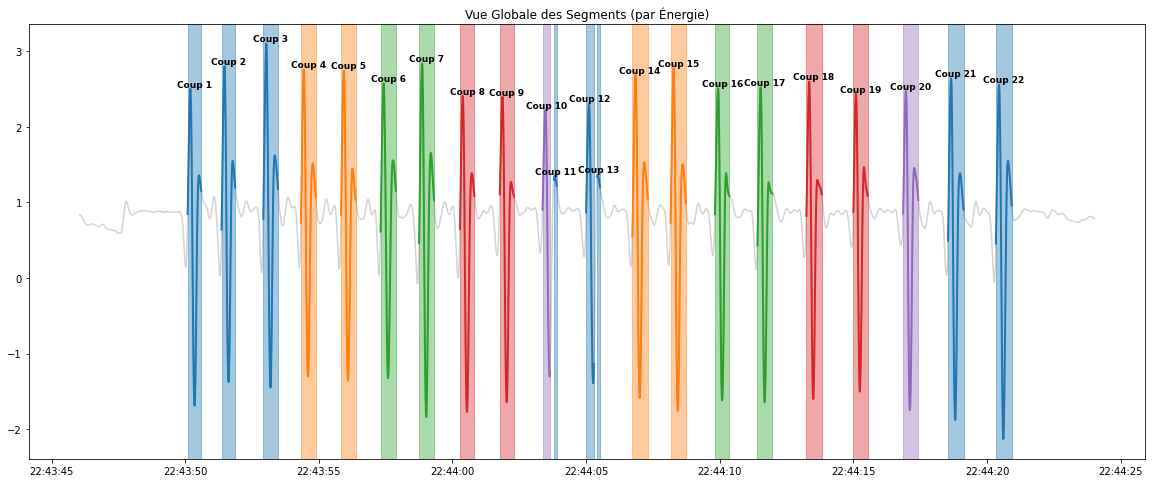


--- Début de la Labellisation Interactive (basée sur segments d'énergie) ---
--- Colonnes de df_reference_session APRÈS lissage global ---
['SeqNum', 'AccX', 'AccY', 'AccZ', 'Roll', 'Pitch', 'Yaw', 'Flex', 'Force1', 'Force2', 'Force3', 'Force4', 'TimestampReception', 'Time', 'AccX_Smoothed', 'AccY_Smoothed', 'AccZ_Smoothed', 'Roll_Smoothed', 'Pitch_Smoothed', 'Yaw_Smoothed', 'AccelMagnitude_Smoothed', 'EnergyEnvelope']

--- Coup Potentiel N° 1/22 ---
(Index originaux: 404 à 455, Début: 22:43:50.092)
Colonnes de df_reference_session avant extraction pour coup 1: ['SeqNum', 'AccX', 'AccY', 'AccZ', 'Roll', 'Pitch', 'Yaw', 'Flex', 'Force1', 'Force2', 'Force3', 'Force4', 'TimestampReception', 'Time', 'AccX_Smoothed', 'AccY_Smoothed', 'AccZ_Smoothed', 'Roll_Smoothed', 'Pitch_Smoothed', 'Yaw_Smoothed', 'AccelMagnitude_Smoothed', 'EnergyEnvelope']
    Min_AccZ_Val calculé et assigné : -3.0383799999999996


KeyboardInterrupt: Interrupted by user

In [16]:
df_reference_session = load_reference_csv_data(REFERENCE_SESSION_CSV)
labeled_features_list = []
final_reference_labels = []
all_extracted_features_for_training = []

if df_reference_session is not None:
    print("\n--- Lissage des Données de Référence ---")
    required_cols_for_smoothing = ['AccX', 'AccY', 'AccZ', 'Roll', 'Pitch', 'Yaw']
    for col in required_cols_for_smoothing:
        if col in df_reference_session.columns:
            df_reference_session[f'{col}_Smoothed'] = smooth_data_knn(df_reference_session[col])
    print("Lissage terminé.")

    # : Calcul de la Magnitude et de l'Enveloppe d'Énergie ---
    df_reference_session['AccelMagnitude_Smoothed'] = calculate_accel_magnitude_smoothed(df_reference_session)
    
    if df_reference_session['AccelMagnitude_Smoothed'] is not None:
        df_reference_session['EnergyEnvelope'] = calculate_energy_envelope(df_reference_session['AccelMagnitude_Smoothed'])
        
        # Visualisation de l'enveloppe d'énergie pour aider au réglage du seuil
        plt.figure(figsize=(20, 6))
        plt.plot(df_reference_session['Time'].to_numpy(), df_reference_session['EnergyEnvelope'].to_numpy(), label='Enveloppe d\'Énergie (Accel Magnitude² Lissée)')
        
        plt.axhline(ENERGY_ACTIVITY_THRESHOLD, color='r', linestyle='--', label=f'Seuil d\'activité ({ENERGY_ACTIVITY_THRESHOLD})')
        plt.title("Enveloppe d'Énergie et Seuil pour la Segmentation")
        plt.xlabel("Temps")
        plt.ylabel("Énergie (arbitraire)")
        plt.legend()
        plt.grid(True)
        plt.show()

        print("\n--- Identification des segments de coups par ÉNERGIE ---")
        detected_segments_indices = segment_coups_par_energie(
            df_reference_session,
            df_reference_session['EnergyEnvelope'],
            activity_threshold=ENERGY_ACTIVITY_THRESHOLD,
            min_duration_samples=MIN_DURATION_SAMPLES_ENERGY,
            merge_gap_samples=MERGE_GAP_SAMPLES_ENERGY
        )
    else:
        print("Magnitude d'accélération n'a pas pu être calculée. Segmentation par énergie impossible.")
        detected_segments_indices = [] # Pas de segments si la magnitude n'est pas là


    if not detected_segments_indices:
        print("Aucun segment de coup potentiel n'a été détecté avec la méthode par énergie.")
    else:
        print(f"\n{len(detected_segments_indices)} segments de coups potentiels détectés par ÉNERGIE.")
        
        clear_output(wait=True)
        print("--- Visualisation Globale des Segments Détectés (par Énergie) ---")
    
        fig_global, ax_global = plt.subplots(figsize=(20, 8))
        ax_global.plot(df_reference_session['Time'].to_numpy(), df_reference_session['AccY_Smoothed'].to_numpy(), label='AccY Lissé', color='lightgray', zorder=1)
        colors = plt.cm.get_cmap('tab10', len(detected_segments_indices) if len(detected_segments_indices) > 0 else 1)
        for i, (p1_idx, p2_idx) in enumerate(detected_segments_indices):
            if p1_idx not in df_reference_session.index or p2_idx not in df_reference_session.index: continue
            segment_data = df_reference_session.loc[p1_idx:p2_idx]
            start_time, end_time = segment_data['Time'].iloc[0], segment_data['Time'].iloc[-1]
            ax_global.axvspan(start_time, end_time, color=colors(i % 10), alpha=0.4, zorder=2)
            text_y_pos = segment_data['AccY_Smoothed'].max() if not segment_data['AccY_Smoothed'].empty else df_reference_session['AccY_Smoothed'].mean()
            ax_global.text(start_time + (end_time - start_time)/2, text_y_pos, f"Coup {i+1}", 
                           horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black', weight='bold', zorder=3)
            ax_global.plot(segment_data['Time'].to_numpy(), segment_data['AccY_Smoothed'].to_numpy(), color=colors(i % 10), linewidth=2, zorder=2)
        ax_global.set_title("Vue Globale des Segments (par Énergie)")
        plt.show()


        print("\n--- Début de la Labellisation Interactive (basée sur segments d'énergie) ---")

        if df_reference_session is not None:
            print("--- Colonnes de df_reference_session APRÈS lissage global ---")
            print(df_reference_session.columns.tolist())


            
            # Boucle de labellisation  :
        for i, (p1_idx, p2_idx) in enumerate(detected_segments_indices):
            if p1_idx not in df_reference_session.index or p2_idx not in df_reference_session.index:
                print(f"Avertissement: Coup {i+1} ignoré (indices hors limites).")
                continue
            print(f"\n--- Coup Potentiel N° {i+1}/{len(detected_segments_indices)} ---")
            print(f"(Index originaux: {p1_idx} à {p2_idx}, Début: {df_reference_session['Time'].loc[p1_idx].strftime('%H:%M:%S.%f')[:-3]})")

            # Dans la boucle de labellisation de la Cellule 4, avant l'appel à extract_features_from_segment
            print(f"Colonnes de df_reference_session avant extraction pour coup {i+1}: {df_reference_session.columns.tolist()}")


            features_dict = extract_features_from_segment(df_reference_session, p1_idx, p2_idx) # Toujours utile
            
            label = input(f"Quel type de coup est-ce (Coup N°{i+1})? (d/c/u/i/q) : ").lower()
            if label == 'q': break
            if label == 'i': continue
            
            current_label_str = ""
            if label == 'd': current_label_str = 'direct'
            elif label == 'c': current_label_str = 'crochet'
            elif label == 'u': current_label_str = 'uppercut'
            final_reference_labels.append(current_label_str)
            all_extracted_features_for_training.append(features_dict)
            print(f"Coup N°{i+1} étiqueté comme : {current_label_str}")


        if label != 'q': # Si on n'a pas quitté
            print("\n--- Labellisation Terminée ---")
            print(f"{len(final_reference_labels)} coups ont été étiquetés.")

            if all_extracted_features_for_training:
                print("\nDEBUG: Contenu de all_extracted_features_for_training (premier élément seulement):")
                if all_extracted_features_for_training:
                    print(all_extracted_features_for_training[0]) 
                else:
                    print("Liste vide.")

                df_training_features_INTERMED = pd.DataFrame(all_extracted_features_for_training)
                print("\nDEBUG: df_training_features_INTERMED (après création depuis liste de dicts):")
                display(df_training_features_INTERMED.head())
                print("\nDEBUG: Colonnes de df_training_features_INTERMED:")
                print(df_training_features_INTERMED.columns.tolist())
                print("\nDEBUG: Informations sur df_training_features_INTERMED:")
                df_training_features_INTERMED.info()


                # Assignation à df_training_features pour la suite
                df_training_features = df_training_features_INTERMED.copy() # Utiliser une copie

                # S'assurer que toutes les colonnes de FEATURES_COLUMNS sont là
                print("\nDEBUG: Vérification/Ajout des colonnes manquantes de FEATURES_COLUMNS...")
                for col_f in FEATURES_COLUMNS: # FEATURES_COLUMNS doit être défini et accessible
                    if col_f not in df_training_features.columns:
                        print(f"DEBUG: Colonne '{col_f}' de FEATURES_COLUMNS non trouvée, ajout avec NaN.")
                        df_training_features[col_f] = np.nan 
                
                # Ajouter Type_Coup si ce n'est pas déjà fait
                if 'Type_Coup' not in df_training_features.columns and len(final_reference_labels) == len(df_training_features):
                     df_training_features['Type_Coup'] = final_reference_labels
                elif 'Type_Coup' not in df_training_features.columns and len(final_reference_labels) != len(df_training_features):
                     print(f"ATTENTION: Longueur de final_reference_labels ({len(final_reference_labels)}) != longueur de df_training_features ({len(df_training_features)}). Colonne Type_Coup non ajoutée automatiquement.")


                print("\nDEBUG: df_training_features AVANT sélection/réorganisation finale des colonnes:")
                display(df_training_features.head())
                print("\nDEBUG: Colonnes de df_training_features AVANT sélection finale:")
                print(df_training_features.columns.tolist())

                # Réorganiser/sélectionner les colonnes dans l'ordre de FEATURES_COLUMNS + Type_Coup

                cols_to_select = FEATURES_COLUMNS[:] # Copie de la liste
                if 'Type_Coup' in df_training_features.columns:
                    cols_to_select.append('Type_Coup')
                else:
                    print("ATTENTION: Colonne 'Type_Coup' non trouvée pour la sélection finale.")
                
                # Filtrer cols_to_select pour ne garder que celles qui existent vraiment dans df_training_features
                # pour éviter un KeyError si une feature de FEATURES_COLUMNS n'a pas pu être créée
                existing_cols_to_select = [col for col in cols_to_select if col in df_training_features.columns]
                df_training_features = df_training_features[existing_cols_to_select]
                
                print("\nDataFrame d'entraînement (features + étiquettes) FINAL généré :")
                display(df_training_features.head())
                print("\nDEBUG: Colonnes de df_training_features FINAL:")
                print(df_training_features.columns.tolist())
                print("\nDEBUG: Informations sur df_training_features FINAL:")
                df_training_features.info()

            else:
                print("Aucune feature n'a été étiquetée pour l'entraînement.")

        # ... (reste de la création de df_training_features)
        if all_extracted_features_for_training:
            df_training_features = pd.DataFrame(all_extracted_features_for_training)
            for col_f in FEATURES_COLUMNS:
                if col_f not in df_training_features.columns: df_training_features[col_f] = np.nan
            df_training_features = df_training_features[FEATURES_COLUMNS]
            df_training_features['Type_Coup'] = final_reference_labels
            print("\nDataFrame d'entraînement généré.")
            display(df_training_features.head())
        if 'df_training_features' in locals() and not df_training_features.empty:
            df_training_features.to_csv('dataset_entrainement_knn.csv', index=False)
            print("\nDataset d'entraînement sauvegardé dans 'dataset_entrainement_knn.csv'")
else:
    print("Impossible de charger le fichier de référence.")